In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# Step 1: Load Dataset

df = pd.read_csv("../dataset/fruit_dataset.csv")
print("Original dataset shape:", df.shape)
print(df.head())


# Step 2: Data Cleaning

# Remove duplicates
df = df.drop_duplicates()

# Fill missing values
fill_values = {
    'season': df['season'].mode()[0],
    'origin': df['origin'].mode()[0],
    'freshness_score': df['freshness_score'].median(),
    'weight': df['weight'].median(),
    'price': df['price'].median()
}
df.fillna(value=fill_values, inplace=True)

print("\nMissing values after cleaning:")
print(df.isnull().sum())

print("\nFinal dataset shape:", df.shape)


# Step 3: One-Hot Encoding

categorical_cols = ['fruit_name', 'season', 'origin']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

#  save cleaned & encoded dataset
df_encoded.to_csv("../dataset/Clean_fruit_dataset_encoded.csv", index=False)


# Step 4: Features & Target

X = df_encoded.drop(columns=['price'])
y = df_encoded['price']


# Step 5: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Step 6: Train Models

# Linear Regression
lr = LinearRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
rf_pred = rf.predict(X_test)


# Step 7: Evaluation Function

def print_metrics(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n{name} Performance:")
    print(f"  R²   : {r2:.3f}")
    print(f"  MAE  : {mae:,.2f}")
    print(f"  RMSE : {rmse:,.2f}")

# Print metrics
print_metrics("Linear Regression", y_test, lr_pred)

print_metrics("Random Forest", y_test, rf_pred)



# Step 8: Single-row Sanity Check
indices = ([10, 30, 21, 67,224]  )
print("\nMulti-row sanity check:")

for i in indices:
    x_one_df = X_test.iloc[[i]]
    y_true = y_test.iloc[i]
    p_lr_one = float(lr.predict(x_one_df)[0])
    p_rf_one = float(rf.predict(x_one_df)[0])
    
    print(f"\nRow {i}:")
    print(f"  Actual Price: ${y_true:,.2f}")
    print(f"  LR Pred     : ${p_lr_one:,.2f}")
    print(f"  RF Pred     : ${p_rf_one:,.2f}")



# Step 9: Save Random Forest Model and linear regression

# linaer

joblib.dump(lr, "../model/lr_fruit_model.pkl")
print("\nLinear Regression model saved as 'lr_fruit_model.pkl'")

# random
joblib.dump(rf, "../model/rf_fruit_model.pkl")
print("\nRandom Forest model saved as 'rf_fruit_model.pkl'")




Original dataset shape: (2000, 6)
  fruit_name  season    origin  freshness_score  weight  price
0     Grapes  Autumn     Local              9.0   0.078   3.93
1     Orange  Summer     Local              6.0   0.233   1.90
2      Mango  Autumn     Local              3.0     NaN   3.49
3     Orange  Summer     Local              7.0   0.341   1.86
4     Orange  Spring  Imported              9.0   0.382   1.56

Missing values after cleaning:
fruit_name         0
season             0
origin             0
freshness_score    0
weight             0
price              0
dtype: int64

Final dataset shape: (1999, 6)

Linear Regression Performance:
  R²   : 0.709
  MAE  : 0.49
  RMSE : 0.63

Random Forest Performance:
  R²   : 0.666
  MAE  : 0.51
  RMSE : 0.67

Multi-row sanity check:

Row 10:
  Actual Price: $2.26
  LR Pred     : $3.37
  RF Pred     : $3.55

Row 30:
  Actual Price: $0.91
  LR Pred     : $1.46
  RF Pred     : $1.49

Row 21:
  Actual Price: $2.63
  LR Pred     : $1.79
  RF Pred  

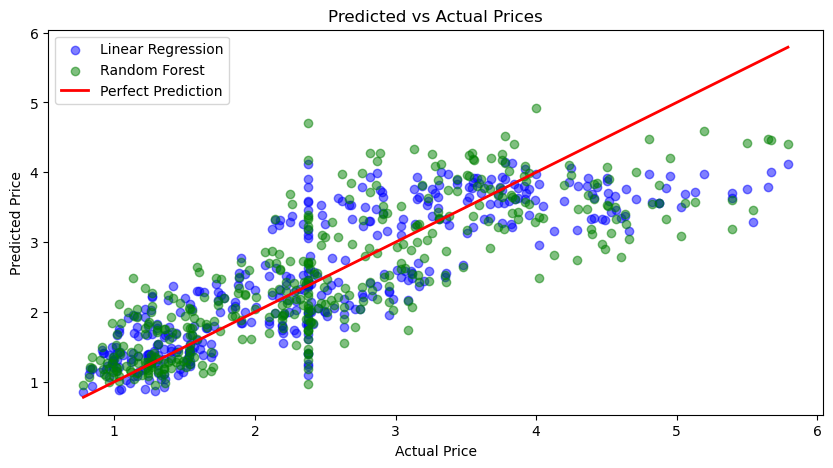

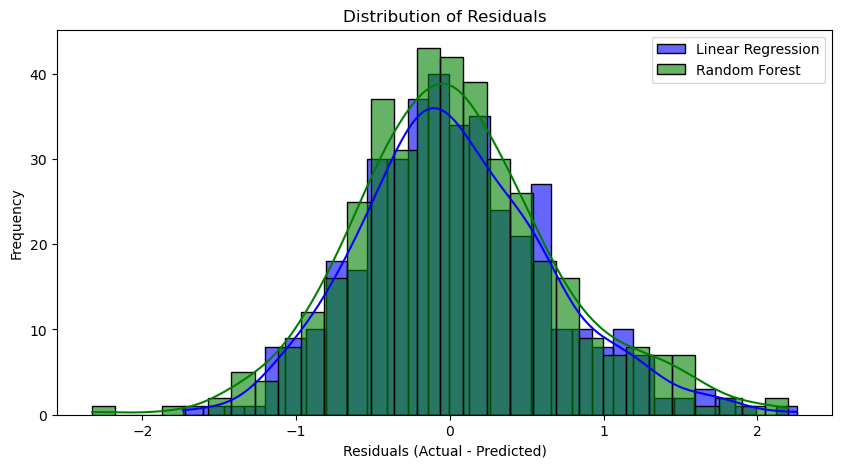

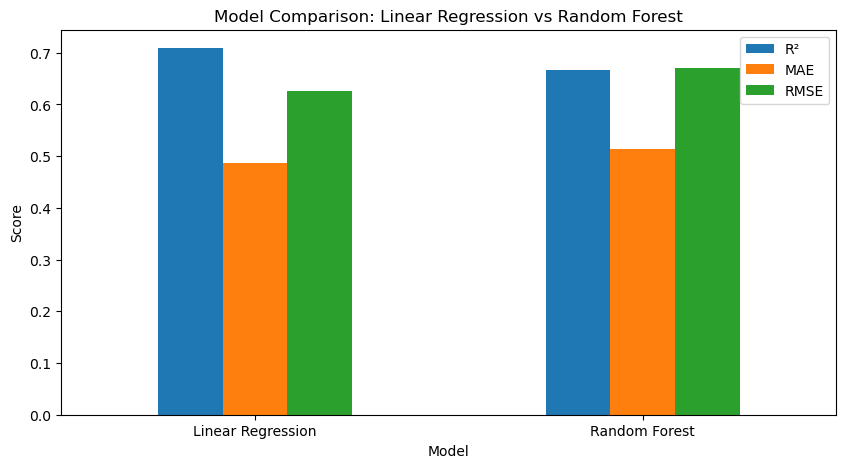

In [21]:
import seaborn as sns

### 📊 Visualizations

# 1️⃣ Scatter plot: Predicted vs Actual Prices
plt.figure(figsize=(10,5))
plt.scatter(y_test, lr_pred, color='blue', alpha=0.5, label='Linear Regression')
plt.scatter(y_test, rf_pred, color='green', alpha=0.5, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Prediction')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.legend()
plt.show()

# 2️⃣ Distribution plot of residuals
residuals_lr = y_test - lr_pred
residuals_rf = y_test - rf_pred

plt.figure(figsize=(10,5))
sns.histplot(residuals_lr, color='blue', label='Linear Regression', kde=True, bins=30, alpha=0.6)
sns.histplot(residuals_rf, color='green', label='Random Forest', kde=True, bins=30, alpha=0.6)
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.legend()
plt.show()

# 3️⃣ Model comparison chart (R², MAE, RMSE)
metrics = {
    "Model": ["Linear Regression", "Random Forest"],
    "R²": [r2_score(y_test, lr_pred), r2_score(y_test, rf_pred)],
    "MAE": [mean_absolute_error(y_test, lr_pred), mean_absolute_error(y_test, rf_pred)],
    "RMSE": [np.sqrt(mean_squared_error(y_test, lr_pred)), np.sqrt(mean_squared_error(y_test, rf_pred))]
}

metrics_df = pd.DataFrame(metrics)
metrics_df.set_index("Model", inplace=True)
metrics_df.plot(kind='bar', figsize=(10,5))
plt.title("Model Comparison: Linear Regression vs Random Forest")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()
